In [1]:
import pandas as pd
import numpy as np
import sklearn
from mamimo.datasets import load_fake_mmm
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] =[12,8]

import warnings
warnings.filterwarnings("ignore")

In [2]:
data=load_fake_mmm()
X=data.drop(columns=['Sales'])
y=data['Sales']

In [3]:
X.columns

Index(['TV', 'Radio', 'Banners'], dtype='object')

##### Plotting the data to see the trends

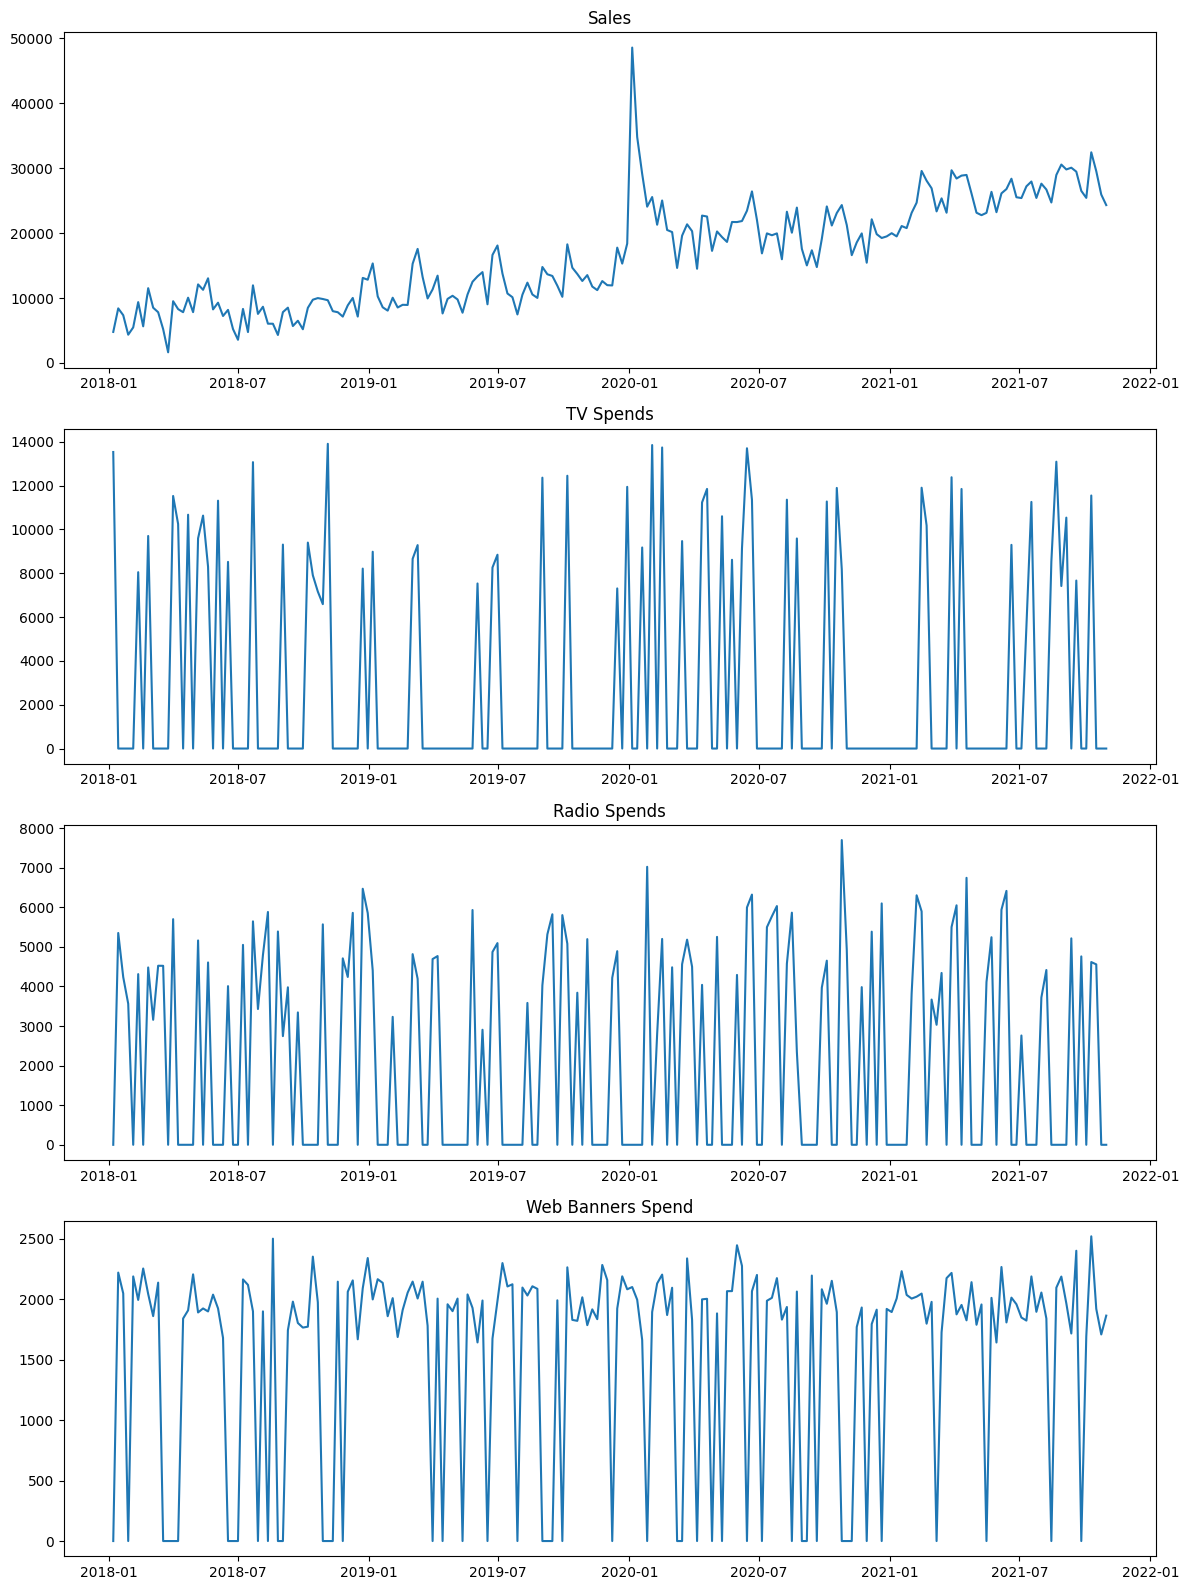

In [4]:
import matplotlib.pyplot as plt
fig, (ax0,ax1,ax2,ax3)=plt.subplots(4,1, figsize=(12,16))
ax0.plot(y.index, y, label='Sales')
ax0.set_title('Sales')

ax1.plot(X.index, X.TV, label='TV')
ax1.set_title('TV Spends')

ax2.plot(X.index, X.Radio, label='Radio')
ax2.set_title('Radio Spends')

ax3.plot(X.index, X.Banners, label='Banners')
ax3.set_title('Web Banners Spend')

plt.tight_layout()



### Incorporating Time features
- Althoght the data has datetime as index, but for learing the temporal aspects of the data creation of time features is necessary.
- Also date(2020-01-05) seems to be a special week ( as sales are very high as compare to surrounding) for the stakes holder thus we need to encode that as well.

So the month, trend and special_date columns are added to the input data

In [5]:
from mamimo.time_utils import add_time_features, add_date_indicators
X=(X.pipe(add_time_features,month=True)
   .pipe(add_date_indicators, special_date=['2020-01-05'])
   .assign(trend=range(len(X))))
X.head()

,TV,Radio,Banners,month,special_date,trend
Date,,,,,,
2018-01-07,13528.1,0.00,0.00,1,0,0
2018-01-14,0.0,5349.65,2218.93,1,0,1
2018-01-21,0.0,4235.86,2046.96,1,0,2
2018-01-28,0.0,3562.21,0.00,1,0,3
2018-02-04,0.0,0.00,2187.29,2,0,4


Train MAPE:  0.11032666997748666
Train MAE:  1410.2615996201598
Train r2:  0.9314472665860652


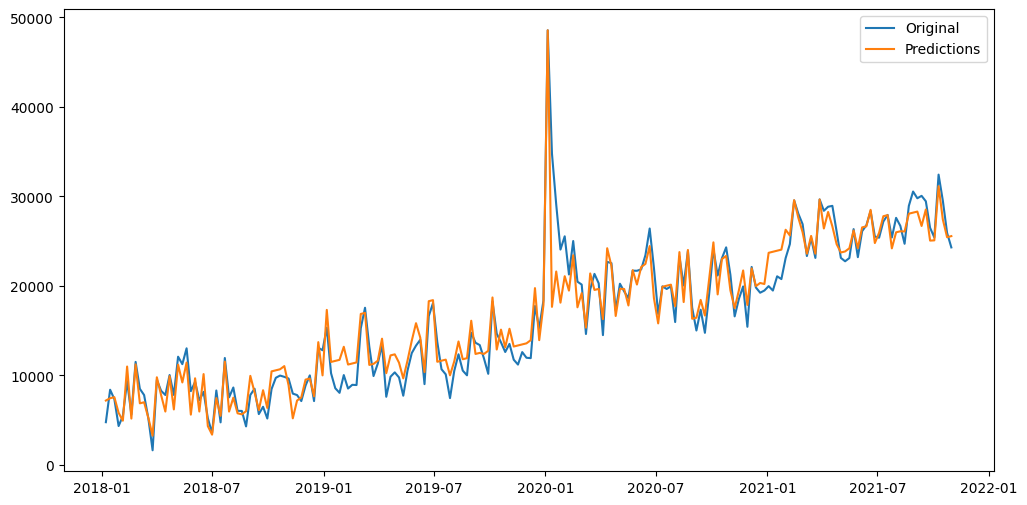

In [6]:
from mamimo.time_utils import PowerTrend
from mamimo.carryover import ExponentialCarryover
from mamimo.saturation import ExponentialSaturation
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error,r2_score

cats =  [list(range(1, 13))] # different months, known beforehand

preprocess = ColumnTransformer(
    [
     ('tv_pipe', Pipeline([
            ('carryover', ExponentialCarryover()),
            ('saturation', ExponentialSaturation())
     ]), ['TV']),
     ('radio_pipe', Pipeline([
            ('carryover', ExponentialCarryover()),
            ('saturation', ExponentialSaturation())
     ]), ['Radio']),
     ('banners_pipe', Pipeline([
            ('carryover', ExponentialCarryover()),
            ('saturation', ExponentialSaturation())
     ]), ['Banners']),
    ('month', OneHotEncoder(sparse=False, categories=cats), ['month']),
    ('trend', PowerTrend(), ['trend']),
    ('special_date', ExponentialCarryover(), ['special_date'])
    ]
)

model = Pipeline([
    ('preprocess', preprocess),
    ('regression', LinearRegression(
        positive=True,
        fit_intercept=False) # no intercept because of the months
    )
])

model.fit(X,y)
predictions=model.predict(X)
pred_df=pd.DataFrame(y)
pred_df['Predictions']=predictions

print('Train MAPE: ', mean_absolute_percentage_error(y,predictions))
print('Train MAE: ', mean_absolute_error(y,predictions))
print('Train r2: ', r2_score(y, predictions))

fig, ax =plt.subplots(figsize=(12,6))
ax.plot(pred_df.index,pred_df['Sales'], label='Original')
ax.plot(pred_df.index, pred_df['Predictions'], label='Predictions')
ax.legend()

##### Above sit seems quite good with MAPE of 11% and R2 of 0.93, but hyperparameter tuning is not a bad idea

Train MAPE:  0.0890744903800913
Train MAE:  1210.7043049194997
Train r2:  0.9492425634302487


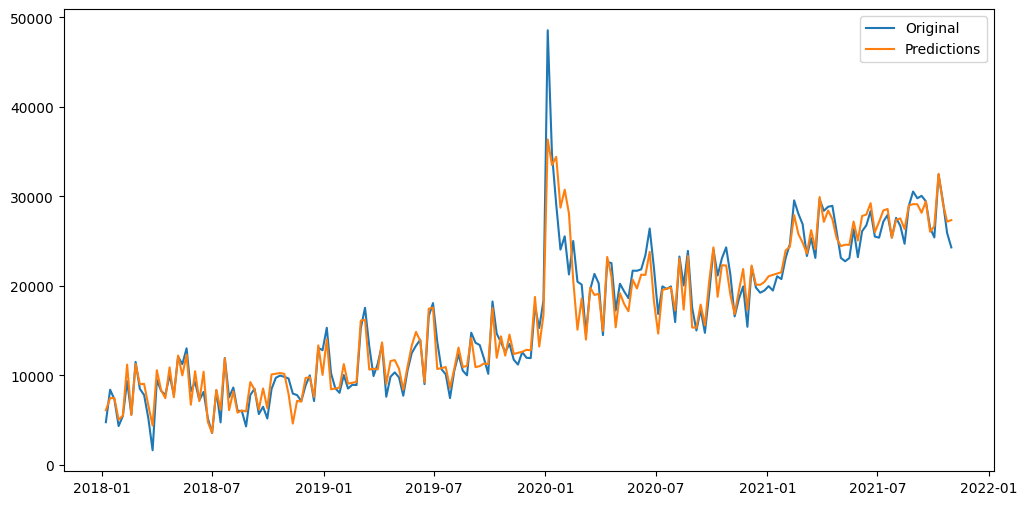

In [7]:
## Instantialting Model
new_model = Pipeline([
    ('preprocess', preprocess),
    ('regression', LinearRegression(
        positive=True,
        fit_intercept=False))]
)

## Hypperparameter Tuning
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

tuned_new_model = RandomizedSearchCV(
  new_model,
  param_distributions={
    'preprocess__tv_pipe__carryover__window': randint(1, 10),
    'preprocess__tv_pipe__carryover__strength': uniform(0, 1),
    'preprocess__tv_pipe__saturation__exponent': uniform(0, 1),
    'preprocess__radio_pipe__carryover__window': randint(1, 10),
    'preprocess__radio_pipe__carryover__strength': uniform(0,1),
    'preprocess__radio_pipe__saturation__exponent': uniform(0, 1),
    'preprocess__banners_pipe__carryover__window': randint(1, 10),
    'preprocess__banners_pipe__carryover__strength': uniform(0, 1),
    'preprocess__banners_pipe__saturation__exponent': uniform(0, 1),
    'preprocess__trend__power': uniform(0, 2),           
    'preprocess__special_date__window': randint(1, 10),  
    'preprocess__special_date__strength': uniform(0, 1), 
  },
  cv=TimeSeriesSplit(),
  random_state=0,
  n_iter=1000, # some more iterations, takes more time
)

tuned_new_model.fit(X, y)
predictions=tuned_new_model.predict(X)
pred_df_tuned=pd.DataFrame(y)
pred_df_tuned['Predictions']=predictions

print('Train MAPE: ', mean_absolute_percentage_error(y,predictions))
print('Train MAE: ', mean_absolute_error(y,predictions))
print('Train r2: ', r2_score(y, predictions))

fig, ax =plt.subplots(figsize=(12,6))
ax.plot(pred_df_tuned.index,pred_df_tuned['Sales'], label='Original')
ax.plot(pred_df_tuned.index, pred_df_tuned['Predictions'], label='Predictions')
ax.legend()

#### The MAPE of tuned model is 8.9% and R2 is 0.94

In [8]:
## Printing the best parameters
tuned_new_model.best_params_

{'preprocess__banners_pipe__carryover__strength': 0.9803750792296568,
 'preprocess__banners_pipe__carryover__window': 1,
 'preprocess__banners_pipe__saturation__exponent': 0.17633290746448915,
 'preprocess__radio_pipe__carryover__strength': 0.9417421432655166,
 'preprocess__radio_pipe__carryover__window': 1,
 'preprocess__radio_pipe__saturation__exponent': 0.06918480469264277,
 'preprocess__special_date__strength': 0.8667029791268241,
 'preprocess__special_date__window': 6,
 'preprocess__trend__power': 1.463860555363072,
 'preprocess__tv_pipe__carryover__strength': 0.3422263312509606,
 'preprocess__tv_pipe__carryover__window': 1,
 'preprocess__tv_pipe__saturation__exponent': 0.3591065076533001}

In [9]:
## Printing the coefficients of the linear Model
best_model = tuned_new_model.best_estimator_
pd.Series(
    best_model.named_steps['regression'].coef_,
    index=best_model[:-1].get_feature_names_out()
)

tv_pipe__TV                    3389.936223
radio_pipe__Radio              2278.722721
banners_pipe__Banners          2455.014529
month__month_1                 2724.333161
month__month_2                 2991.294001
month__month_3                 4080.414725
month__month_4                 4542.696384
month__month_5                 3484.384661
month__month_6                 3785.648380
month__month_7                 2497.006408
month__month_8                 2068.016356
month__month_9                 1883.746542
month__month_10                2179.914536
month__month_11                2135.526587
month__month_12                2233.341183
trend__trend                      9.801207
special_date__special_date    96822.051231
dtype: float64

#### Computing The Channel Contributions

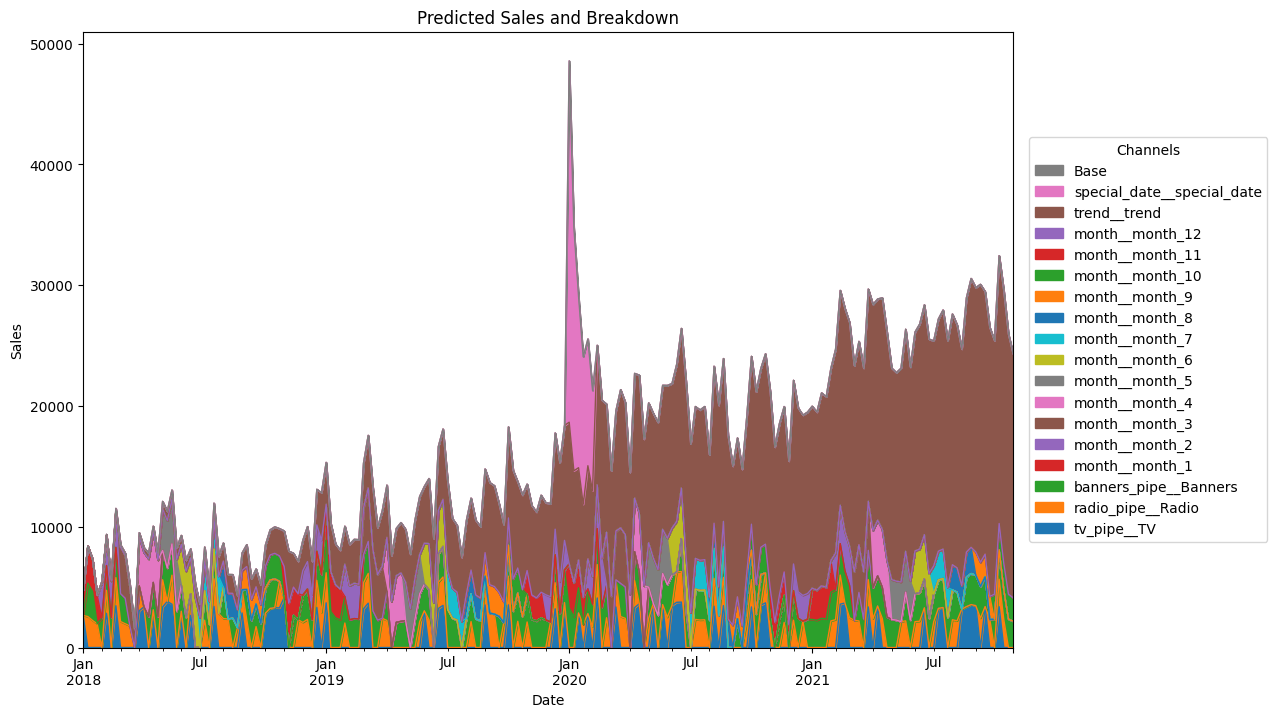

In [10]:
from mamimo.analysis import breakdown

contributions = breakdown(tuned_new_model.best_estimator_, X, y)
ax = contributions.plot.area(
    figsize=(12, 8),
    linewidth=1,
    title="Predicted Sales and Breakdown",
    ylabel="Sales",
    xlabel="Date",
)

handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles[::-1],
    labels[::-1],
    title="Channels",
    loc="center left",
    bbox_to_anchor=(1.01, 0.5),
)

In [11]:
## Grouping channels as above plot is difficult to understand (grouping base, ternd and month columns in one)
group_channels = {
    'Baseline': [f'month__month_{i}' for i in range(1, 13)] + ['Base', 'trend__trend']
} # read: 'Baseline consists of the months, base and trend.'
  # You can add more groups!

contributions = breakdown(
    tuned_new_model.best_estimator_,
    X,
    y,
    group_channels
)
contributions.columns = [
    'TV', 'Radio', 'Banners',
    'Special Date', 'Baseline'
]
contributions

,TV,Radio,Banners,Special Date,Baseline
Date,,,,,
2018-01-07,2650.065959,0.000000,0.000000,0.0,2129.734041
2018-01-14,0.000000,2564.894810,2763.326123,0.0,3077.499067
2018-01-21,0.000000,2238.769807,2411.970684,0.0,2703.129509
2018-01-28,0.000000,1962.555920,0.000000,0.0,2388.494080
2018-02-04,0.000000,0.000000,2433.684835,0.0,3039.235165
...,...,...,...,...,...
2021-10-03,0.000000,0.000000,2338.159866,0.0,23084.460134
2021-10-10,3380.984221,2272.705165,2448.531429,0.0,24339.499185
2021-10-17,0.000000,2296.827107,2474.519548,0.0,24765.333345


Text(0.5, 1.0, 'Predicted Sales and Breakdown')

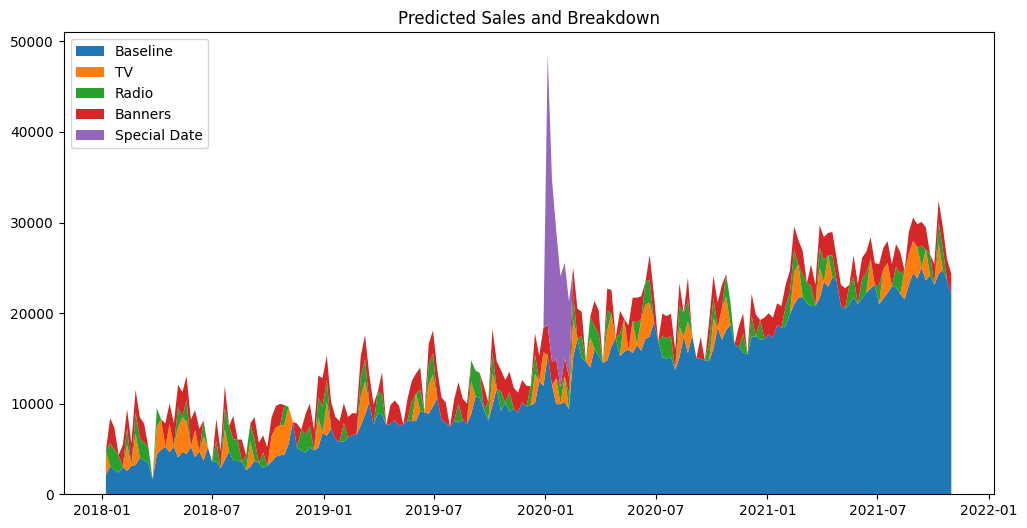

In [12]:
contributions
fig, axis=plt.subplots(figsize=(12,6))
axis.stackplot(contributions.index,contributions.Baseline, contributions.TV, contributions.Radio,
              contributions.Banners,contributions['Special Date'],
               labels=['Baseline','TV','Radio','Banners','Special Date'])
axis.legend(loc='upper left')
axis.set_title('Predicted Sales and Breakdown')

##### It clearly shows that the baseline incereases with time, this is quite expected in media modelling

#### Calculating Return on Investment (ROI) of each channel

In [13]:
for channel in ['TV', 'Radio', 'Banners']:
    roi = contributions[channel].sum() / X[channel].sum()
    print(f'{channel}: {roi:.2f}')

TV: 0.33
Radio: 0.47
Banners: 1.23


In [14]:
### It is quite evident that the return on Invest is much higher for bannerrs as compared to others